In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv
from scipy.fft import fft as npfft
from scipy.fft import ifft as npifft
import pandas as pd
import pickle

def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)


class synth_series():
    """
    Irregular land motion synthetic model
    """
    
    def __init__(self,specs={},name='ilame'):
        self.specs    = self.make_specs(specs)
        self.name     = name 
        self.noise    = 0 #make_noise(self)
        self.annual   = 0 #make_annual(self)
        self.offsets  = 0 #make_offsets(self)
        self.trend    = 0 #make_trend_change(self)  
        self.samples  = 0 #self.initialize_data()
        self.time     = 0
        self.x        = 0
        self.y        = 0
        self.series   = 0

    def make_specs(self,specs_in):
        """
        all units are 'mm'
        
        """
        specs={}
        
        specs['duration'] = 20.                   # years
        specs['gaps'] = .05                       # %
        specs['resolution'] = 'M'                 # 
        specs['sigma_noise'] = 25.                # mm
        specs['coeff_AR1'] =   .3                 # mm        
        specs['annual_cycle_amplitude'] = 20.      # %
        
        specs['offsets'] = False                  # %
        specs['trend_changes'] = False            # %
        specs['n_changepoints'] = 0 
        specs['offset_positions'] = [10]          #  %
        specs['offset_positions_uniform'] = False  #  % distribute uniformely
        
                
        specs['min_space_ratio'] = 4.
        specs['offset_sigma'] = False             #  if True set offset_size is sigma of normal distribution
                                                  #, else: size is absolute
        specs['offset_uniform'] = False
        specs['offset_size'] = [1.]                 #  %
        specs['trend_change_sigma'] = False       #  if True set trend_change_size is sigma of normal distribution
                                                  #, else: size is absolute
        specs['trend_change_size'] = [1.]         #  mm/year  
        specs['base_trend'] = 0.                  #  mm/year     
        
        specs['PLWN']=False
        specs['sigma_pl']=25
        specs['spectral_index']=-0.8
        specs['random_seed']=None
        
        for item in specs_in:
            specs[item]=specs_in[item]        
        
        return specs
    
    def make_series(self):    
        y = self.noise + self.annual + self.offsets + self.trend
        y = self.make_gaps(y)
        series = pd.Series(y,self.time)
        
        return y,series                                                                                      

    def initialize_data(self):   
        
        year_end=int(1995 + self.specs['duration'])        
        self.time=pd.date_range(start='1/1/1995', end='1/1/'+str(year_end),freq=self.specs['resolution'])
        self.samples = len(self.time)
        
        if self.specs['resolution'] == 'M':
            res_factor=12.
        elif self.specs['resolution'] == 'W':
            res_factor=52.
        elif self.specs['resolution'] == 'D':
            res_factor=365.5

        self.x = np.arange(self.samples)/res_factor # float in ['years']

        if self.specs['offset_positions_uniform']:
            print('distribute offsets uniformly')

            self.specs['offset_positions'] = np.random.permutation(np.linspace(0+1,                                                                               self.specs['duration']-1,                                                                               int((self.samples-res_factor*2)/                                                                               self.specs['min_space_ratio'])))[0:self.specs['n_changepoints']]
            
            
                                              
                                                                
                
        self.noise    = self.make_noise()
        self.corr_noise    = None
        self.annual   = self.make_annual()
        self.offsets  = self.make_offsets()
        self          = self.make_trend_change()  
        self.y,self.series   = self.make_series()
        
        
        
    def make_noise(self):
        """ makes PL+WN or AR1 noise   
        
        """
        
        if self.specs['PLWN']:            
            N=len(self.x)
             # Flicker noise
            h = np.zeros(2*N) # Note the size : 2N
            h[0] = 1 # Eq. (25)
            for i in range(1,N):
                h[i] = (i-self.specs['spectral_index']/2-1)/i * h[i-1]

            v = np.zeros(2*N) # Again zero-padded N:2N
            
            #if specs['random_seed']!=None:
                
            
            v[0:N] = np.random.normal(loc = 0.0, scale = self.specs['sigma_pl'], size = N)
            white= np.random.normal(loc = 0.0, scale = self.specs['sigma_noise'], size = N)
            pl = np.real(npifft(npfft(v) * npfft(h))) # Eq. (39)
            self.corr_noise=pl[0:N]
            noise = pl[0:N] +white          
        else:
            noise = np.random.normal(0, self.specs['sigma_noise'], self.samples)
            s_ar1 = noise*self.specs['coeff_AR1']
            noise[1:]=noise[1:]+s_ar1[:-1]            
        return noise
    
    def make_annual(self):
        period=1 # 1 year
        return self.specs['annual_cycle_amplitude']*np.sin(self.x*2*np.pi/(period))
    
    def make_offsets(self):
        
        if self.specs['n_changepoints'] == 0:
            return 0
        else:
            positions = self.specs['offset_positions']
            
            if self.specs['offset_sigma']:
                offsets = np.random.normal(0, self.specs['offset_size'], self.specs['n_changepoints'])   
            elif self.specs['offset_uniform']:
                offsets = np.random.uniform(self.specs['offset_size'][0],
                                            self.specs['offset_size'][1],
                                            self.specs['n_changepoints'])    
                
                # allow for plus minus offsets
                sett = np.random.normal(0,2,self.specs['n_changepoints'])
                sett = sett/abs(sett)
                offsets=offsets*sett
                print('set offsets automatically:')
                print('offsets: ', offsets)
                print('positions: ', positions)
                
            else:  
                offsets = np.array(self.specs['offset_size'])
                
            A = (self.x[:, None] >= positions) * 1
            offset_change = det_dot(A, offsets)
        return offset_change
    
    def make_trend_change(self):     
        if self.specs['n_changepoints'] == 0:
            self.trend = self.x * self.specs['base_trend']
            return self
        elif self.specs['trend_changes']:
            positions = self.specs['offset_positions']
            
            if self.specs['trend_change_sigma']:
                trend_inc = np.random.normal(0, self.specs['trend_change_size'], self.specs['n_changepoints'])  
                print('trend: ', trend_inc)
            else:  
                trend_inc = np.array(self.specs['trend_change_size'])
                
            A = (self.x[:, None] >= positions) * 1
            gamma = -np.asarray(positions) * trend_inc

            trend_inc=det_dot(A, trend_inc)
            trend=self.specs['base_trend']+trend_inc
            A_gamma=det_dot(A, gamma)
            self.offsets=self.offsets + A_gamma
            self.trend = self.x * trend
        return self
    
    def make_gaps(self,y):
        
        r = np.random.uniform(0,self.samples -1 ,int(self.samples * self.specs['gaps'])).astype(int)
        y[r] = np.nan
        return y
    
    def plot(self):
        print('not yet implemented')
        
        
    def save(self,save_dir='',allow_pickle=True):
        """
        save object
        """
        print('save synth')
        if self.name == '' or save_dir=='':
            raise Exception('Define Object.name and save_dir before saving!')
        else:
            if allow_pickle:
                with open(save_dir+self.name+'.sy', 'wb') as ilame_file:
                    pickle.dump(self, ilame_file, pickle.HIGHEST_PROTOCOL)


    def load(save_dir='',name='',allow_pickle=True):
        """
        load object
        """
        if name == '' or save_dir=='':
            raise Exception('Define name and save_dir before loading!')
        else:
            if allow_pickle:
                with open(save_dir+name+'.sy', 'rb') as ilame_file:
                    self = pickle.load(ilame_file)  
            else:
                self=np.load(save_dir+name+'.npy',allow_pickle=True)

            return self

pl noise:  6.811751305651004


Text(0.5, 1.0, 'PL + white noise')

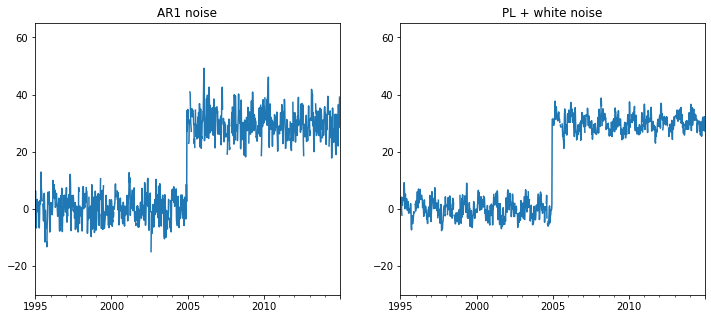

In [5]:
sampling='W'

specs= {}
specs['duration'] = 20.                   # years
specs['gaps'] = .05                       # %
specs['resolution'] = sampling               # 
specs['sigma_noise'] = 4.# 3.2                # mm
specs['coeff_AR1'] =   .45 #.45                # mm        
specs['annual_cycle_amplitude'] = 2.5      # %

specs['offsets'] = True                  # %
specs['trend_changes'] = False            # %
specs['n_changepoints'] = 1 
specs['offset_positions'] = [10]          #  %
specs['offset_sigma'] = False             #  if True set offset_size is sigma of normal distribution
                                          #, else: size is absolute
specs['offset_size'] = [30.]                 #  %
specs['trend_change_sigma'] = False       #  if True set trend_change_size is sigma of normal distribution
                                          #, else: size is absolute
specs['trend_change_size'] = [0.]         #  mm/year  
specs['base_trend'] = 0                  #  mm/year  

synt_standard = synth_series(specs=specs)
synt_standard.specs=synt_standard.make_specs(specs)
synt_standard.initialize_data()

specs['PLWN']=False
specs['PLWN']=False
driving_noise=4
specs['sigma_noise'] = driving_noise * 0.5
specs['sigma_pl']=driving_noise * 0.7
specs['spectral_index']=-.9


print('pl noise: ',specs['sigma_pl']/ ((1/52)**(-specs['spectral_index']/4)))

synt_pl = synth_series(specs=specs)
synt_pl.specs=synt_pl.make_specs(specs)
synt_pl.initialize_data()

fig, axs = plt.subplots(1,2,figsize=(12,5))


synt_standard.series.plot(ax=axs[0])
min_=-30
max_=65
axs[0].set_title('AR1 noise')
axs[0].set_ylim(min_,max_)
synt_pl.series.plot(ax=axs[1])
axs[1].set_ylim(min_,max_)
max_=35
axs[1].set_title('PL + white noise')